In [2]:
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import pickle
import json
from database.comet import Comet
from processor.processor import Processor as p
from time import sleep
import matplotlib.pyplot as plt
import math
from backtester.entry import Entry
from backtester.exit_strats import ExitStrats

In [3]:
comet = Comet()

In [4]:
comet.connect()
prices = comet.retrieve(f"alpha_prices")
comet.disconnect()

In [5]:
prices["crypto"].unique()

array(['ADA', 'BTC', 'CAKE', 'DOGE', 'ETH', 'SHIB', 'XTZ', 'XRP', 'LUNA',
       'AVAX', 'LTC', 'DOT'], dtype=object)

In [14]:
symbols = ['ADA', 'BTC',
#            'DOGE', 
           'ETH', 
#            'SHIB', 
           'LUNA',
       'AVAX', 'LTC', 'DOT']

In [7]:
# symbols = prices["crypto"].unique()

In [15]:
prices[prices["crypto"]=="ADA"].mean()

C:\Users\eric\AppData\Local\Temp/ipykernel_16360/1337500535.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  prices[prices["crypto"]=="ADA"].mean()
C:\Users\eric\AppData\Local\Temp/ipykernel_16360/1337500535.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  prices[prices["crypto"]=="ADA"].mean()


open     0.603945
high     0.631784
low      0.573897
close    0.605041
dtype: float64

In [17]:
api = "coinbase"
retrack_days = [1,3,7,14]
signals = range(0,60,10)
reqs = range(10,60,10)
entry_strats = ["standard","signal_based","parameter_defined","all"]
exit_strats = [
                "due_date","hold","adaptive_due_date",
    "adaptive_hold"]
trades = []
market = prices.pivot_table(index="date",columns="crypto",values="close").reset_index()
market = p.column_date_processing(market)
market = market.fillna(method="ffill")
start = datetime(2021,1,1)
end = datetime(2022,12,31)
for conservative in tqdm([True,False],desc="conservative"):
    for value in tqdm([True,False],desc="value"):
        for rt in tqdm(retrack_days,desc="retrack_days"):
            sim = market.melt(id_vars="date").copy()
            ns = []
            for crypto in sim["crypto"].unique():
                crypto_sim = sim[sim["crypto"]==crypto].copy()
                crypto_sim.sort_values("date",inplace=True)
                crypto_sim["signal"] = crypto_sim["value"].pct_change(rt)
                crypto_sim["velocity"] = crypto_sim["signal"].pct_change(rt)
                crypto_sim["inflection"] = crypto_sim["velocity"].pct_change(rt)
                crypto_sim["p_sign_change"] = [row[1]["velocity"] * row[1]["inflection"] < 0 for row in crypto_sim.iterrows()]
                ns.append(crypto_sim)
            final = pd.concat(ns)
            final = final[(final["date"] < end) & (final["crypto"].isin([x.lower() for x in symbols]))]
            for entry_strat in tqdm(entry_strats,desc="entry"):
                for exit_strat in exit_strats:
                    for s in signals:
                        for r in reqs:
                            signal = float(s/100)
                            req = float(r/100)
                            date = start
                            while date < end:
                                try:
                                    match entry_strat:
                                        case "standard":
                                            offerings = Entry.standard(final,date,signal,value,conservative)
                                        case "signal_based":
                                            offerings = Entry.signal_based(final,date,signal,value,conservative)
                                        case "parameter_defined":
                                            offerings = Entry.parameter_defined(final,date,signal,value,conservative)
                                        case "all":
                                            offerings = Entry.all(final,date,signal,value,conservative)
                                        case _:
                                            offerings = pd.DataFrame([{}])
                                    if offerings.index.size < 1:
                                        date = date + timedelta(days=1)
                                    else:
                                        trade = offerings.iloc[0]
                                        match exit_strat:
                                            case "due_date":
                                                trade = ExitStrats.due_date(final,trade,rt,req)
                                            case "hold":
                                                trade = ExitStrats.hold(final,trade,rt,req)
                                            case "adaptive_due_date":
                                                trade = ExitStrats.adaptive_due_date(final,trade,rt,req)
                                            case "adaptive_hold":
                                                trade = ExitStrats.adaptive_hold(final,trade,rt,req)
                                            case _:
                                                trade = {}
                                        trade["signal"] = signal
                                        trade["req"] = req
                                        trade["retrack_days"] = rt
                                        trade["value"] = value
                                        trade["conservative"] = conservative
                                        trade["entry_strategy"] = entry_strat
                                        trade["exit_strategy"] = exit_strat
                                        trades.append(trade)
                                        date = trade["sell_date"] + timedelta(days=1)
                                except Exception as e:
                                    print(date,str(e))
                                    date = date + timedelta(days=1)

value:   0%|                                                                                                                                           | 0/2 [00:00<?, ?it/s]

retrack_days:   0%|                                                                                                                                    | 0/4 [00:00<?, ?it/s]


entry:   0%|                                                                                                                                           | 0/4 [00:00<?, ?it/s]E:\projects\comet_venv\comet\comet\ml\backtester\exit_strats.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exits["delta"] = (exits["value"] - bp) / bp
C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pa

2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of




entry:  25%|████████████████████████████████▊                                                                                                  | 1/4 [00:36<01:50, 36.74s/it]

2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of




entry:  50%|█████████████████████████████████████████████████████████████████▌                                                                 | 2/4 [01:21<01:23, 41.57s/it]


entry:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3/4 [02:34<00:55, 55.62s/it]


entry: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:01<00:00, 60.42s/it]


retrack_days:  75%|████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3/4 [12:20<04:05, 245.52s/it]


entry:   0%|                                                                                                                                           | 0/4 [00:00<?, ?it/s]

2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of




entry:  25%|████████████████████████████████▊                                                                                                  | 1/4 [00:35<01:47, 35.68s/it]


entry:  50%|█████████████████████████████████████████████████████████████████▌                                                                 | 2/4 [01:19<01:20, 40.33s/it]

2022-01-06 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-06 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-06 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-06 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of




entry:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3/4 [02:27<00:53, 53.15s/it]


entry: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:48<00:00, 57.23s/it]


retrack_days: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [16:10<00:00, 242.53s/it]

value:  50%|█████████████████████████████████████████████████████████████████                                                                 | 1/2 [16:10<16:10, 970.10s/it]

retrack_days:   0%|                                                                                                                                    | 0/4 [00:00<?, ?it/s]


entry:   0%|                                                                                                           

2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds





entry:  50%|█████████████████████████████████████████████████████████████████▌                                                                 | 2/4 [01:21<01:22, 41.18s/it]


entry:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3/4 [02:35<00:56, 56.58s/it]


entry: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:43<00:00, 55.77s/it]


retrack_days:  25%|██████████████████████████████▊                                                                                            | 1/4 [03:43<11:10, 223.66s/it]


entry:   0%|                                                                                                                                           | 0/4 [00:00<?, ?it/s]


entry:  25%|████████████████████████████████▊                                                                        

2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds





entry:  25%|████████████████████████████████▊                                                                                                  | 1/4 [00:37<01:51, 37.01s/it]

2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds





entry:  50%|█████████████████████████████████████████████████████████████████▌                                                                 | 2/4 [01:23<01:25, 42.74s/it]


entry:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3/4 [02:38<00:57, 57.49s/it]


entry: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:08<00:00, 62.04s/it]


retrack_days:  75%|████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3/4 [12:40<04:12, 252.86s/it]


entry:   0%|                                                                                                                                           | 0/4 [00:00<?, ?it/s]

2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of




entry:  25%|████████████████████████████████▊                                                                                                  | 1/4 [00:37<01:51, 37.22s/it]


entry:  50%|█████████████████████████████████████████████████████████████████▌                                                                 | 2/4 [01:22<01:24, 42.24s/it]

2022-01-06 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-06 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-06 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-06 00:00:00 single positional indexer is out-of-bounds
2022-01-07 00:00:00 single positional indexer is out-of-bounds
2022-01-08 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of




entry:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3/4 [02:32<00:54, 54.53s/it]


entry: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:56<00:00, 59.15s/it]


retrack_days: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [16:37<00:00, 249.46s/it]

value:  50%|█████████████████████████████████████████████████████████████████                                                                 | 1/2 [16:37<16:37, 997.83s/it]

retrack_days:   0%|                                                                                                                                    | 0/4 [00:00<?, ?it/s]


entry:   0%|                                                                                                           

In [18]:
t = pd.DataFrame(trades)

In [19]:
analysis = []
for conservative in [True,False]:
    for value in [True,False]:
        for entry_strat in entry_strats:
            for exit_strat in tqdm(exit_strats,desc="exit"):
                for rt in retrack_days:
                    for s in tqdm(signals):
                        for r in reqs:
                            try:
                                signal = float(s/100)
                                req = float(r/100)
                                iteration_trades = t[(t["signal"]==signal) 
                                                     & (t["req"]==req) 
                                                     & (t["retrack_days"]==rt) 
                                                     & (t["value"]==value) 
                                                     & (t["conservative"]==conservative)
                                                    & (t["entry_strategy"]==entry_strat)
                                                     & (t["exit_strategy"]==exit_strat)
                                                    ].sort_values("sell_date",ascending=True)
                                initial = 100
                                for delta in iteration_trades["delta"]:
                                     initial = initial * (1+delta)
                                iteration_trades["hpr"] = iteration_trades["sell_date"] - iteration_trades["date"]
                                iteration_trades["days"] = [x.days for x in iteration_trades["hpr"]]
                                days = iteration_trades["days"].mean()
                                analysis.append({"signal":signal,"req":req,"trades":iteration_trades.index.size,"pv":initial,"days":days,"retrack_days":rt,"value":value,"conservative":conservative,"entry_strategy":entry_strat,"exit_strategy":exit_strat})
                            except Exception as e:
                                print(str(e))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 22.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 24.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 23.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 24.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.80it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 23.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.66it/s]

exit: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


In [20]:
a = pd.DataFrame(analysis)
a.sort_values("pv",ascending=False).head(30)

,signal,req,trades,pv,days,retrack_days,value,conservative,entry_strategy,exit_strategy
6221,0.2,0.2,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6220,0.2,0.1,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6224,0.2,0.5,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6223,0.2,0.4,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6222,0.2,0.3,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6195,0.3,0.1,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
6196,0.3,0.2,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
6197,0.3,0.3,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
6198,0.3,0.4,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
6199,0.3,0.5,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold


In [21]:
a[a["exit_strategy"]=="adaptive_hold"].sort_values("pv",ascending=False).head(10)

,signal,req,trades,pv,days,retrack_days,value,conservative,entry_strategy,exit_strategy
6220,0.2,0.1,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6222,0.2,0.3,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6223,0.2,0.4,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6224,0.2,0.5,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6221,0.2,0.2,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6195,0.3,0.1,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
6199,0.3,0.5,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
6198,0.3,0.4,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
6197,0.3,0.3,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
6196,0.3,0.2,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold


C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


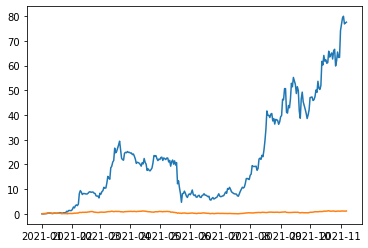

In [22]:
api = "alpha"
goods = a.sort_values("pv",ascending=False).head(10).iloc[0]
current_trades = t[(t["signal"]==goods["signal"].item())
                       & (t["req"]==goods["req"].item())
                        & (t["retrack_days"]==goods["retrack_days"].item())
                          & (t["value"]==goods["value"].item())
                            & (t["conservative"]==goods["conservative"].item())
                   & (t["entry_strategy"]==goods["entry_strategy"])
                   & (t["exit_strategy"]==goods["exit_strategy"])
                  ]
current_trades.sort_values("sell_date",inplace=True)
if current_trades.index.size > 1:
    viz = []
    row = current_trades.iloc[0]
    pv = 100
    start_date = row["date"]
    symbol = row["crypto"]
    amount = float(pv/row["buy_price"])
    end_date = row["sell_date"]
    pv2 = amount * row["sell_price"]
    viz.append({"date":start_date,"crypto":symbol,"amount":amount})
    viz.append({"date":end_date,"crypto":symbol,"amount":amount})
    track_date = start_date
    while track_date < end_date - timedelta(days=1):
        track_date = track_date + timedelta(days=1)
        viz.append({"date":track_date,"crypto":symbol,"amount":amount})
    for i in range(1,current_trades.index.size-1):
        row = current_trades.iloc[i]
        symbol = current_trades.iloc[i]["crypto"]
        start_date = row["date"]
        pv = pv2
        amount =  pv /row["buy_price"]
        viz.append({"date":start_date,"crypto":symbol,"amount":amount})
        track_date = start_date
        end_date = row["sell_date"]
        while track_date < end_date:
            track_date = track_date + timedelta(days=1)
            viz.append({"date":track_date,"crypto":symbol,"amount":amount})
        pv2 = amount * row["sell_price"]
        viz.append({"date":end_date,"crypto":symbol,"amount":amount})
    window = pd.DataFrame(viz)
    example = final.merge(window,how="left",on=["date","crypto"])
    example = example.dropna().sort_values("date")
    example["actual"] = example["amount"] * example["value"]
    example = example.merge(market[["date","btc"]],on="date",how="left")
    example["bench_delta"] = (example["btc"] - example["btc"].iloc[0]) / example["btc"].iloc[0]
    example["actual_delta"] = (example["actual"] - example["actual"].iloc[0]) / example["actual"].iloc[0]
#     if example["actual"].max() < 10000:
    plt.plot(example["date"],example["actual_delta"])
    plt.plot(example["date"],example["bench_delta"])
plt.show()

In [23]:
symbol_analysis = []
for symbol in current_trades["crypto"].unique():
    symbol_trades = current_trades[current_trades["crypto"]==symbol]
    trades = symbol_trades.index.size
    initial = 1
    for delta in symbol_trades["delta"]:
        initial = initial * 1+delta
    symbol_return = initial
    symbol_trades["hpr"] = symbol_trades["sell_date"] - symbol_trades["date"]
    symbol_trades["days"] = [x.days for x in symbol_trades["hpr"]]
    symbol_analysis.append({"symbol":symbol,"return":initial,"trades":trades,"hpr":symbol_trades["days"].mean()})

C:\Users\eric\AppData\Local\Temp/ipykernel_16360/922708580.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_trades["hpr"] = symbol_trades["sell_date"] - symbol_trades["date"]
C:\Users\eric\AppData\Local\Temp/ipykernel_16360/922708580.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_trades["days"] = [x.days for x in symbol_trades["hpr"]]


In [24]:
initial

1.5202328966521104

In [25]:
pd.DataFrame(symbol_analysis).sort_values("return",ascending=False)

,symbol,return,trades,hpr
0,luna,11.158699,4,70.25
3,dot,1.520233,1,62.00
2,ltc,1.264775,1,16.00
1,eth,1.065329,1,8.00


In [26]:
initial = 100
for delta in current_trades["delta"]:
    initial = initial * (1+delta)
    print(initial,1+delta)
initial

122.22222222222223 1.2222222222222223
921.3675213675215 7.538461538461539
981.5597829096749 1.065329263454842
4085.0320881046077 4.161776143675317
5166.645519134429 1.2647747698676397
7854.50448352838 1.5202328966521104
9710.047748107767 1.2362393793867752


9710.047748107767

In [27]:
current_trades

,date,crypto,value,signal,velocity,inflection,p_sign_change,type,sell_price,sell_date,buy_price,delta,req,retrack_days,conservative,entry_strategy,exit_strategy
8626,2021-01-01,luna,False,0.2,0.188930,-1.456094,True,profit,0.792,2021-01-15,0.6480,0.222222,0.2,14,False,standard,adaptive_hold
8641,2021-01-16,luna,False,0.2,0.210689,-0.903258,True,profit,5.733,2021-02-12,0.7605,6.538462,0.2,14,False,standard,adaptive_hold
6669,2021-02-13,eth,False,0.2,1.591418,-3.012080,True,profit,1933.530,2021-02-21,1814.9600,0.065329,0.2,14,False,standard,adaptive_hold
8678,2021-02-22,luna,False,0.2,-0.960164,-1.031638,False,profit,29.430,2021-08-19,7.0715,3.161776,0.2,14,False,standard,adaptive_hold
7857,2021-08-20,ltc,False,0.2,0.262271,-1.075281,True,profit,232.200,2021-09-05,183.5900,0.264775,0.2,14,False,standard,adaptive_hold
5874,2021-09-06,dot,False,0.2,-0.346820,0.362210,True,profit,52.220,2021-11-07,34.3500,0.520233,0.2,14,False,standard,adaptive_hold
8937,2021-11-08,luna,False,0.2,1.777249,2.672308,False,held,66.930,2022-01-09,54.1400,0.236239,0.2,14,False,standard,adaptive_hold


In [28]:
nice= pd.DataFrame(analysis)
nice.sort_values("pv",ascending=False).head(30)

,signal,req,trades,pv,days,retrack_days,value,conservative,entry_strategy,exit_strategy
6221,0.2,0.2,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6220,0.2,0.1,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6224,0.2,0.5,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6223,0.2,0.4,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6222,0.2,0.3,7,9710.047748,52.428571,14,False,False,standard,adaptive_hold
6195,0.3,0.1,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
6196,0.3,0.2,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
6197,0.3,0.3,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
6198,0.3,0.4,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
6199,0.3,0.5,6,7139.585141,59.333333,7,False,False,standard,adaptive_hold
